# COVID-19 Testing Dashboard

This dashboard presents graphs displaying data on COVID-19 testing from Public Health England: the number of tests carried out and the testing capacity per day. You will be able to download current data, view tests/capacity individually and view the graphs in linear/logarithm mode. 

In [1]:
import ipywidgets as wdg # Interactive controls
import pandas as pd # Cleaning
import numpy as np 
import matplotlib.pyplot as plt # Visualisation
import json # File format
from uk_covid19 import Cov19API # SDK which automatically requests PHE API and packages response in nice format
import datetime

In [2]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [3]:
with open("test_comp.json", "rt") as INFILE:
    file_data = json.load(INFILE) # Data from Mar - Nov 2020 stored in JSON file

## A comparison of tests carried out and testing capacity (April - Nov 2020)

In [16]:
def parse_date(datestring):
        """ Convert a date string into a pandas datetime object """
        return pd.to_datetime(datestring, format="%Y-%m-%d")

def wrangle_data(file_data):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """

    datalist = file_data['data']
    datalist

    dates=[dictionary['Date'] for dictionary in datalist ]
    dates.sort()
    dates

    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])


    index = pd.date_range(startdate, enddate, freq='D')
    global test_compdf
    test_compdf = pd.DataFrame(index=index, columns=['Tests', 'Capacity'])
    test_compdf

    for entry in datalist:
        date = parse_date(entry['Date'])
        for column in ['Tests', 'Capacity']:
            if pd.isna(test_compdf.loc[date, column]): 
                value= float(entry[column]) if entry[column]!=None else 0.0
                test_compdf.loc[date, column] = value


    test_compdf.fillna(0.0, inplace=True)

    test_compdf

def plot_random_walk():
    test_compdf.plot() # Visualisation

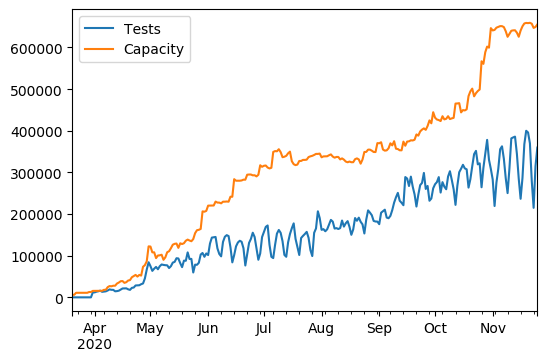

In [17]:
df = wrangle_data(file_data) # Apply cleaning function
ef = plot_random_walk() # Apply visualisation function
ef

## Download current data

Please click on the button to download the latest data. This data is updated every day to include the latest testing and testing capacity figures.

In [21]:
def access_api():
    filters = [
        'areaType=overview'   
    ]

    structure = {
        "Date":"date",
        "Tests":"newTestsByPublishDate",
        "Capacity":"plannedCapacityByPublishDate"
    } # Defines which data fields you want to request
    
    api = Cov19API(filters = filters, structure = structure) # Pass filters/structure to SDK
    test_comp = api.get_json() # Sends request and returns response in JSON format
    return test_comp

In [22]:
apibutton=wdg.Button(
    description='Testing Data',
    disabled=False,
    button_style='danger',
    tooltip="Click to load latest COVID-19 data.",
    icon='thermometer'
) # Attributes of button 

def api_button_callback(button):
    apidata=access_api()
    test_compdf = wrangle_data(apidata)
    apibutton.icon = "check"

apibutton.on_click(api_button_callback) # After button is clicked, download new data from API and wrangle it

graph = wdg.interactive_output(plot_random_walk,{}) # Show this data in graphical format

display(apibutton, graph)

Button(button_style='danger', description='Testing Data', icon='thermometer', style=ButtonStyle(), tooltip='Cl…

Output()

## Graphs and Analysis

In [15]:
series = wdg.SelectMultiple(
options = ['Tests', 'Capacity',],
value = ['Tests', 'Capacity'],
rows = 2,
disabled = False
)

scale=wdg.RadioButtons(
options=['linear', 'log'],
description='Scale:',
disabled=False
)

test_compdf = pd.read_pickle("test_compdf.pkl") # Use data from April-Nov 2020 stores in pickle file

controls=wdg.HBox([series, scale])

def test_comp_graph(gcols, gscale): 
    if gscale == 'linear':
        logscale = False 
        print("As the second wave took hold in Oct/Nov, testing capacity increased significantly and the actual number of tests increased more steadily.")
    else:
        logscale = True
        print("There was clearly exponential propagation of tests and testing capacity at the start of the pandemic!")
        
    ncols=len(gcols) 
    if ncols > 0:
        test_compdf[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("Press Ctrl-Click or Cmd-Click to select more than one category")
    
    plt.xlabel('Date')
    plt.ylabel('Number of Tests')
      
graph=wdg.interactive_output(test_comp_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()

Created by Luis Fernandes (C) 2020 All rights reserved. Based on UK Government data published by Public Health England: https://coronavirus.data.gov.uk